# Import

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from random import choice

In [23]:
df_sales_raw = pd.read_csv("train.csv", low_memory=False)
df_store_raw = pd.read_csv("store.csv", low_memory=False)

# Data preparation

## Merge

In [24]:
df_raw = pd.merge(df_sales_raw, df_store_raw, on="Store", how="left")

## Data Types

In [70]:
df_raw["CompetitionOpenSinceMonth"] = df_raw["CompetitionOpenSinceMonth"].astype(int)
df_raw["CompetitionOpenSinceYear"] = df_raw["CompetitionOpenSinceYear"].astype(int)
df_raw["Promo2SinceWeek"] = df_raw["Promo2SinceWeek"].astype(int)
df_raw["Promo2SinceYear"] = df_raw["Promo2SinceYear"].astype(int)

In [25]:
df_raw["Date"] = df_raw["Date"].astype("datetime64")

## Excluding Columns and Rows

In [158]:
df_raw = df_raw[(df_raw["Open"] == 1) & (df_raw["Sales"] > 0)]

# Since we're using the model to predict sales, there's no way of knowing the number of customers in advance
df_raw = df_raw.drop(["Customers", "Open"], axis=1)

## Handling NaN

In [26]:
df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [27]:
max_distance = df_raw.CompetitionDistance.max()
print(max_distance)

75860.0


In [28]:
df_raw["CompetitionDistance"] = df_raw["CompetitionDistance"].fillna(max_distance)

In [29]:
df_raw["CompetitionOpenSinceMonth"] = df_raw.apply(lambda x: x["Date"].month if pd.isna(x["CompetitionOpenSinceMonth"]) else x["CompetitionOpenSinceMonth"], axis=1)

In [30]:
df_raw["CompetitionOpenSinceYear"] = df_raw.apply(lambda x: x["Date"].year if pd.isna(x["CompetitionOpenSinceYear"]) else x["CompetitionOpenSinceYear"], axis=1)

In [31]:
# When there's no promotion, we choose a random interval to try not to introduce biases to the data
df_raw["PromoInterval"] = df_raw["PromoInterval"].apply(lambda x: choice(['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']) if pd.isna(x) else x)

In [32]:
df_raw["Promo2SinceYear"] = df_raw.apply(lambda x: x["Date"].year if pd.isna(x["Promo2SinceYear"]) else x["Promo2SinceYear"], axis=1)

In [33]:
df_raw["Promo2SinceWeek"] = df_raw.apply(lambda x: x["Date"].week if pd.isna(x["Promo2SinceWeek"]) else x["Promo2SinceWeek"], axis=1)

In [34]:
df_raw["StateHoliday"] = df_raw["StateHoliday"].apply(lambda x: "public_holiday" if x=="a" else "easter" if x=="b" else "christmas" if x=="c" else x)

In [35]:
df_raw["Assortment"] = df_raw["Assortment"].apply(lambda x: "basic" if x=="a" else "extra" if x=="b" else "extended")

# Descriptive Statistics

In [36]:
df1 = df_raw.copy()
num_attributes = df1.select_dtypes(include=["int64", "float64"])

In [37]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T

,mean,median,std,min,max,skew,kurtosis
Store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
DayOfWeek,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
Sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
Customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
Open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
Promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
SchoolHoliday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
CompetitionDistance,5613.013481,2330.0,8498.338271,20.0,75860.0,3.599472,19.780674
CompetitionOpenSinceMonth,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
CompetitionOpenSinceYear,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


[Text(0, 0, 'Basic'), Text(1, 0, 'Extra'), Text(2, 0, 'Extended')]

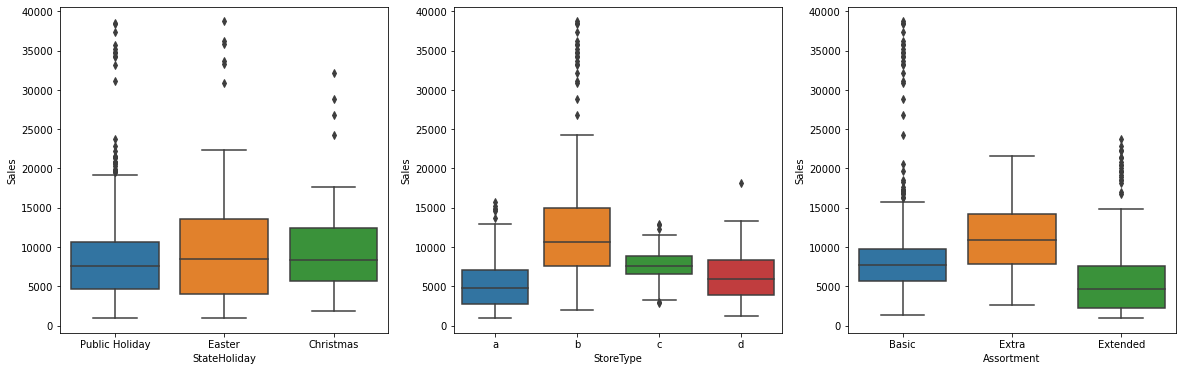

In [39]:
aux = df1[(df1["StateHoliday"] != "0") & (df1["Sales"] > 0)]
fig, ax = plt.subplots(figsize=(20,6))
ax1 = plt.subplot(1,3,1)
sns.boxplot(x="StateHoliday", y="Sales", data=aux, order=["public_holiday","easter","christmas"], ax=ax1)
ax1.set_xticklabels(["Public Holiday","Easter","Christmas"])
ax2 = plt.subplot(1,3,2)
sns.boxplot(x="StoreType", order=["a","b","c","d"], y="Sales", data=aux, ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.boxplot(x="Assortment", y="Sales", order=["basic","extra","extended"], data=aux, ax=ax3)
ax3.set_xticklabels(["Basic", "Extra", "Extended"])

# Feature Engineering

## Hypotheses

1. Stores with extra assortment sell more
2. Stores with closer competition sell less
3. Stores sell less on state holidays
4. Stores sell less on school holidays
5. Stores sell more as time goes on
6. Stores sell less on weekends


## Hypothesis Testing

### Data Manipulation

In [72]:
df2 = df1.copy()

In [95]:
df2["CompetitionSince"] = df2.apply(lambda x: pd.Timestamp( year=x["CompetitionOpenSinceYear"], month=x["CompetitionOpenSinceMonth"], day=1), axis=1)
df2["CompetitionSinceMonths"] = (((df2["Date"] - df2["CompetitionSince"]).apply(lambda x: x.days))/30).astype(int)

In [141]:
df2["Promo2Since"] = (df2["Promo2SinceYear"].astype(str) + "-" + df2["Promo2SinceWeek"].astype(str) + "-1")
df2["Promo2Since"] = df2["Promo2Since"].apply(lambda x: datetime.datetime.strptime(x, "%G-%V-%u"))
df2["Promo2AgeWeeks"] = ((df2["Date"] - df2["Promo2Since"])/7).apply(lambda x: x.days).astype(int)

In [153]:
df2.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionSince,CompetitionSinceMonths,Promo2Since,Promo2AgeWeeks
623111,612,5,2013-12-20,11453,670,1,1,0,0,d,...,11,2012,1,31,2009,"Jan,Apr,Jul,Oct",2012-11-01,13,2009-07-27,229
703479,700,3,2013-10-09,4721,535,1,1,0,0,a,...,10,2013,1,27,2013,"Jan,Apr,Jul,Oct",2013-10-01,0,2013-07-01,14
364813,402,6,2014-08-16,5703,643,1,0,0,0,c,...,9,2011,1,13,2010,"Jan,Apr,Jul,Oct",2011-09-01,36,2010-03-29,228
939596,437,1,2013-03-11,4516,447,1,0,0,0,c,...,3,2013,1,50,2010,"Jan,Apr,Jul,Oct",2013-03-01,0,2010-12-13,117
999359,1105,4,2013-01-17,1946,263,1,0,0,0,c,...,11,2008,1,5,2013,"Feb,May,Aug,Nov",2008-11-01,51,2013-01-28,-2


In [91]:
(df2.Date - df2.CompetitionSince).apply(lambda x: x.)

0          2524
1          2829
2          3164
3          2159
4           121
           ... 
1017204    -516
1017205    2467
1017206       0
1017207       0
1017208       0
Length: 1017209, dtype: int64

In [77]:
df2[-5:]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionSince
1017204,1111,2,2013-01-01,0,0,0,0,public_holiday,1,a,basic,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",2014-06-01
1017205,1112,2,2013-01-01,0,0,0,0,public_holiday,1,c,extended,1880.0,4,2006,0,1,2013,"Mar,Jun,Sept,Dec",2006-04-01
1017206,1113,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,9260.0,1,2013,0,1,2013,"Feb,May,Aug,Nov",2013-01-01
1017207,1114,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,870.0,1,2013,0,1,2013,"Jan,Apr,Jul,Oct",2013-01-01
1017208,1115,2,2013-01-01,0,0,0,0,public_holiday,1,d,extended,5350.0,1,2013,1,22,2012,"Mar,Jun,Sept,Dec",2013-01-01


In [130]:
datetime.datetime.strptime("2015-01-1", "%G-%V-%u")

datetime.datetime(2014, 12, 29, 0, 0)

In [155]:
pd.Timestamp("2013-01-17").week

3